In [2]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [3]:
def color_grayscale_arr(arr, forground_color, background_color):
    """Converts grayscale image"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])#增加一个“通道”维度
    if background_color == "black":
        if forground_color == "red":
            arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)#创建全零数组作为绿色和蓝色通道，表示全红色
        elif forground_color == "green":
            arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
        elif forground_color=="blue":
            arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              np.zeros((h, w, 1), dtype=dtype),
                              arr], axis=2)
        elif forground_color == "white":
            arr = np.concatenate([arr, arr, arr], axis=2)
    else:
        if forground_color == "yellow":
            arr = np.concatenate([arr, arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
        else:
            arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype), arr], axis=2)

        c = [255, 255, 255]
        arr[:, :, 0] = (255 - arr[:, :, 0]) / 255 * c[0]
        arr[:, :, 1] = (255 - arr[:, :, 1]) / 255 * c[1]
        arr[:, :, 2] = (255 - arr[:, :, 2]) / 255 * c[2]
        #0.299*R + 0.587*G + 0.114*B
    #arr[:,:,0]=0.299*arr[:,:,0]+0.587*arr[:,:,1]+0.114*arr[:,:,2]
    return arr


class ColoredMNIST(datasets.VisionDataset):

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'train3', 'test1', 'test2']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt',
                                               weights_only=False)
        elif env == 'all_train':
            train1_data = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt'),
                                                weights_only=False ) 
            train2_data=torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'),
                                                weights_only=False)
            train3_data=torch.load(os.path.join(self.root, 'ColoredMNIST', 'train3.pt'),
                                                weights_only=False)
            self.data_label_tuples = train1_data + train2_data + train3_data
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, train3, test1, test2, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train3.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test2.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        train3_set = []
        test1_set, test2_set = [], []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)
            
            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Color the image according to its environment label

            if idx < 10000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "red", background_color = "black")
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 20000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "green", background_color = "black")
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 30000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "white", background_color = "black")
                train3_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 45000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "yellow", background_color = "white")
                test1_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                colored_arr = color_grayscale_arr(im_array, forground_color = "blue", background_color = "white")
                test2_set.append((Image.fromarray(colored_arr), binary_label))
                
            # Image.fromarray(colored_arr).save('./data/sample/{}.png'.format(idx))

        if not os.path.exists(colored_mnist_dir):
            os.makedirs(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(train3_set, os.path.join(colored_mnist_dir, 'train3.pt'))
        torch.save(test1_set, os.path.join(colored_mnist_dir, 'test1.pt'))
        torch.save(test2_set, os.path.join(colored_mnist_dir, 'test2.pt'))

In [4]:
import random
class RandomColoring(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def _generate_random_color(self):
        #生成一个随机的RGB颜色元组，值在[0, 1]之间
        return (random.random(), random.random(), random.random())

    def forward(self, tensor_image: torch.Tensor) -> torch.Tensor:
        #这个变换要在ToTensor之后做，注意：ToTensor会把颜色的三通道放在第一个维度！！
       
        #识别前景和背景，黑色背景中有值的就是数字
        #从通道检查，如果该位置任意个通道有值，那它就是数字所在的位置，这将返回一个28*28的掩码数组，表示对应位置有没有数字
        foreground_mask=torch.any(tensor_image > 0, dim=0)
        background_mask=~foreground_mask
        #print(foreground_mask)

        #生成随机的前景色和背景色
        foreground_color=self._generate_random_color()
        background_color=self._generate_random_color()
        #如果颜色太近重新生成
        while torch.linalg.norm(torch.tensor(foreground_color)-torch.tensor(background_color))< 0.5:
            background_color = self._generate_random_color()

        #先创建一个用背景色填充的图像
        new_image = torch.zeros_like(tensor_image)
        new_image[0,:, :] = background_color[0]
        new_image[1,:, :] = background_color[1]
        new_image[2,:, :] = background_color[2]
        
        #在新图像上使用掩码将有数字的位置设置为前景色
        new_image[0,foreground_mask] = foreground_color[0]
        new_image[1,foreground_mask] = foreground_color[1]
        new_image[2,foreground_mask] = foreground_color[2]
        
        return new_image

In [5]:
#预处理过程

train_transform=transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # 随机裁剪并缩放  
    # transforms.RandomGrayscale(p=0.1),       # 随机灰度化
    #degrees旋转角度（最大20度），translate平移的最大距离（宽度的0.1倍），shear剪切变换的角度范围
    # transforms.RandomAffine(degrees=20, translate=(0.1, 0.1),shear=10, scale=(0.9, 1.1)),  
    transforms.ToTensor(),
    RandomColoring(),
    # transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # 随机擦除，scale擦除区域的面积范围，ratio擦除区域的宽高比的范围
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [6]:
print("Loading")
train_dataset1=ColoredMNIST(root='./data', env='train1', transform=train_transform)
train_dataset2= ColoredMNIST(root='./data', env='train2', transform=train_transform)
train_dataset3= ColoredMNIST(root='./data', env='train3', transform=train_transform)
test_dataset1= ColoredMNIST(root='./data', env='test1', transform=test_transform)
test_dataset2= ColoredMNIST(root='./data', env='test2', transform=test_transform)

# 打印数据集大小，确认加载成功
print(f"Size of train_dataset_1: {len(train_dataset1)}")
print(f"Size of test_dataset_2: {len(test_dataset2)}")

Loading
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Size of train_dataset_1: 10000
Size of test_dataset_2: 15000


In [7]:

see1=next(iter(train_dataset1))
see2=next(iter(test_dataset1))
print(see1[0].shape,see2[0].shape)

torch.Size([3, 28, 28]) torch.Size([3, 28, 28])


In [8]:
from torch.utils.data import DataLoader,ConcatDataset
#把所有训练集搞在一起
all_train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])

BATCH_SIZE = 128
#dataloader
my_train_loader = DataLoader(dataset=all_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
my_test_loader1 = DataLoader(dataset=test_dataset1, batch_size=BATCH_SIZE, shuffle=False)
my_test_loader2 = DataLoader(dataset=test_dataset2, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total training{len(all_train_dataset)}")
print(f"Test1 {len(test_dataset1)}")
print(f"Test2 {len(test_dataset2)}")

Total training30000
Test1 15000
Test2 15000


Visualizing a batch from DataLoader:


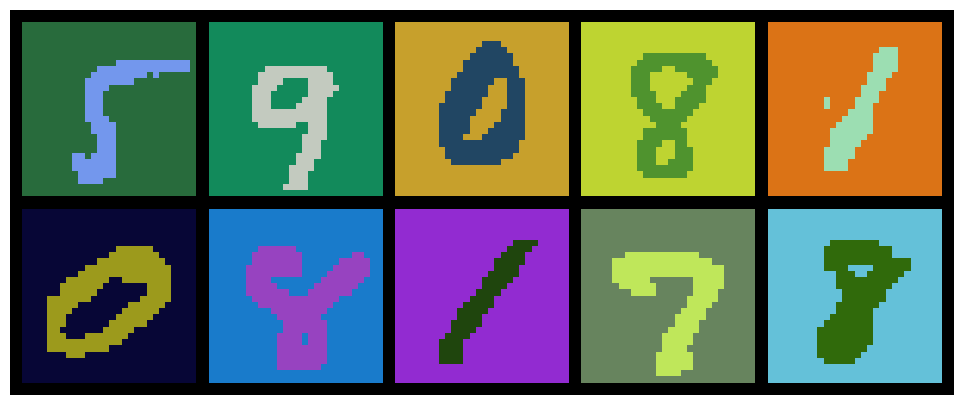

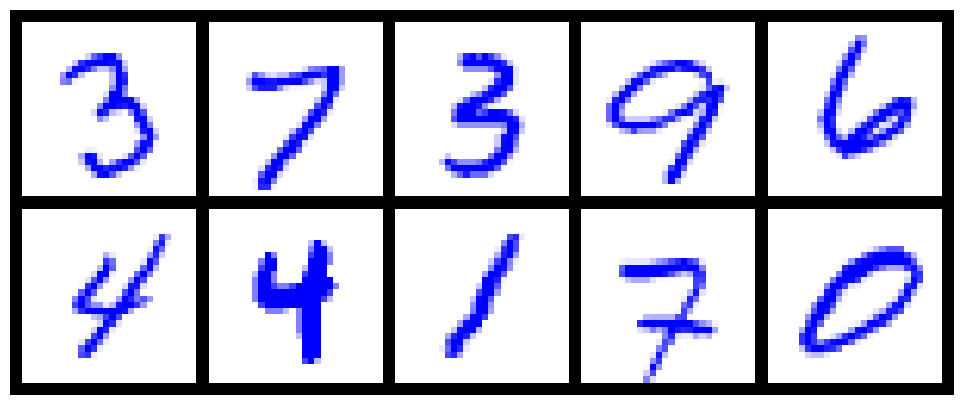

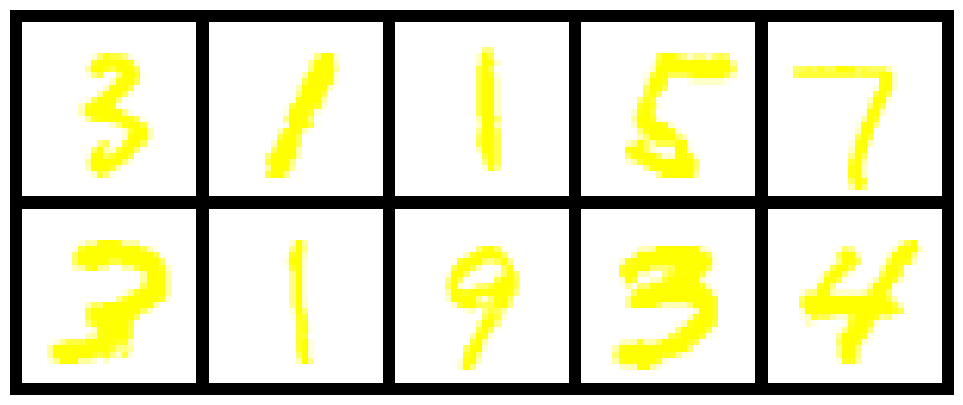

In [9]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def show_batch(data_loader):
    # 从数据加载器中获取一个批次的数据
    images, labels = next(iter(data_loader))
    images=images[:10]
    labels=labels[:10]
    #print(images,labels)
    # 逆标准化
    images = denormalize(images)
    # 创建一个图像网格
    # nrow 是每行显示的图片数量
    grid = torchvision.utils.make_grid(images, nrow=5)

    # 将 Tensor 转换为 NumPy 数组并调整维度顺序 (C, H, W) -> (H, W, C)
    np_grid = grid.permute(1, 2, 0).numpy()
    #return
    # 显示图像
    plt.figure(figsize=(15, 5))
    plt.imshow(np_grid)
    #plt.title(f'Batch Labels{labels[:5].tolist()}')
    plt.axis('off')
    plt.show()

from torchvision.datasets import FakeData


# 模拟


print("Visualizing a batch from DataLoader:")
show_batch(my_train_loader)
show_batch(my_test_loader1)
show_batch(my_test_loader2)

In [10]:
#模型结构和前向传播
class LeNet5(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5) #展平操作
        x_features = self.classifier[:-1](x)
        output=self.classifier[-1](x_features)
        return output

In [11]:
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {my_device}")

Using device: cuda


In [12]:
my_model=LeNet5(num_classes=2).to(my_device)

In [13]:
#损失函数和优化器
my_loss=nn.CrossEntropyLoss()
my_optimizer=optim.Adam(my_model.parameters(), lr=0.001)


In [14]:
NUM_EPOCHS = 30  # 可改为任意轮数

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def train(model, train_loader, loss, optimizer, device, test_loader1, test_loader2):
    print("\nStarting training")
    history = {
        'train_loss': [],
        'train_acc': [],
        'test1_acc': [],
        'test2_acc': []
    }
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        total_train = correct_train = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss1 = loss(outputs, labels)
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()
            running_loss += loss1.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # 测试两个测试集
        test1_acc = test_model(model, test_loader1, device)
        test2_acc = test_model(model, test_loader2, device)

        # 存储历史记录
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test1_acc'].append(test1_acc)
        history['test2_acc'].append(test2_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test1 Acc: {test1_acc:.2f}%, "
              f"Test2 Acc: {test2_acc:.2f}%")

    print("Finished")
    return history

# 调用时传入测试集
my_history = train(my_model, my_train_loader, my_loss, my_optimizer, my_device,
                   my_test_loader1, my_test_loader2)



Starting training
Epoch [1/30], Train Loss: 0.4463, Train Acc: 75.88%, Test1 Acc: 93.91%, Test2 Acc: 87.36%


KeyboardInterrupt: 

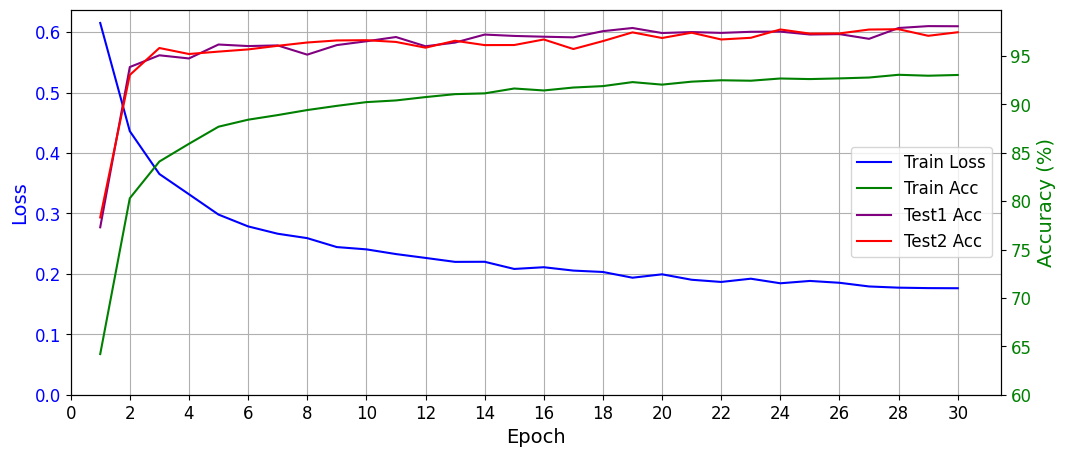

In [ ]:
def plot_history(history):
    import matplotlib.pyplot as plt
    
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    # 主坐标轴：Loss
    ax1 = plt.gca()
    ax1.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)
    ax1.set_xticks(range(0, len(epochs)+1, 2))
    ax1.grid(True)

    # 副坐标轴：Accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['train_acc'], label='Train Acc', color='green')
    ax2.plot(epochs, history['test1_acc'], label='Test1 Acc', color='purple')
    ax2.plot(epochs, history['test2_acc'], label='Test2 Acc', color='red')
    ax2.set_ylabel('Accuracy (%)', color='green', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
    ax2.set_ylim(bottom=60)

    # 图例整合
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=12)

    #plt.title('Training Loss and Accuracy', fontsize=16)
    plt.show()


plot_history(my_history)


In [ ]:
#测试集准确率
test_model(my_model,my_test_loader1,my_device)
test_model(my_model,my_test_loader2,my_device)

97.44

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
from torchvision import transforms
import numpy as np

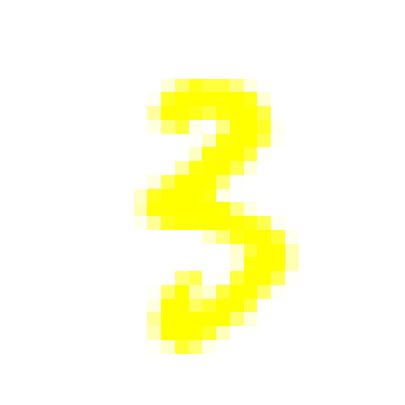

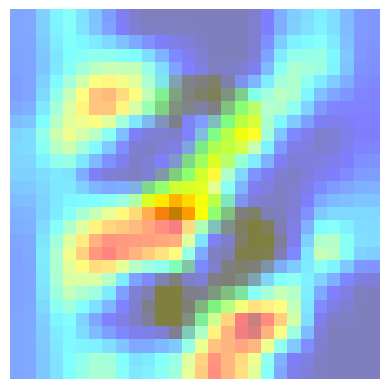

In [ ]:
my_model.eval()

# 逆标准化函数，用于显示图片
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    tensor = tensor.clone().permute(1, 2, 0) # C, H, W -> H, W, C
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

def visualize_grad_cam(model, image_tensor, original_image_np):
    # 选择一个目标层 (通常是最后一个卷积层)
    target_layers = [model.features[3]]

    #创建Grad-CAM对象
    cam = GradCAM(model=model, target_layers=target_layers)
    
    #定义目标类别 (我们想看模型为什么会把它分成某一类)
    #如果不指定，默认是得分最高的类别
    #targets = [ClassifierOutputTarget(class_index)] 
    targets = None 

    #生成CAM
    grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :] # 取第一个结果

    #将CAM叠加到原图上
    visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
    
    #绘图
    plt.figure(figsize=(15, 5))
    plt.imshow(original_image_np)
    plt.axis('off')
    plt.show()
    
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()
    
    
sample=next(iter(test_dataset2)) 
ood_image_tensor=sample[0]
original_image_np = denormalize(ood_image_tensor)
visualize_grad_cam(my_model, ood_image_tensor, original_image_np)